In [138]:
import sys; sys.path.insert(0, '../')
from notebook_tools import *
sqrt2pi = 2*np.pi
%matplotlib inline

# generate synthetic data sample

In [330]:
MAX = 5000000
def measure(n):
    """Measurement model, return two coupled measurements."""
    PcmX, PcmY , PcmZ , Pmiss = [], [] , [] , []
    
    for i in range(MAX):        
        x = np.random.uniform(-0.8,0.8)
        y = np.random.uniform(-0.8,0.8)
        z = np.random.uniform(-0.3,1.4)
        pm = np.random.uniform(-0.3,1.)
    
        probability = Gaussian3DwithOffset( (x , y, z , pm) , amplitude=1,
                                       sigma_t=0.155, a1=0.143 , a2=0.159 , b1=0.562 , b2=0.159 )
        uniform = np.random.uniform(0,1.5)
        if uniform<probability:        
            PcmX.append(x)
            PcmY.append(y) 
            PcmZ.append(z) 
            Pmiss.append(pm)
            if (len(Pmiss)%(n/5)==0): print len(Pmiss),'samples so far...'
        if len(Pmiss)>n: break
    return np.array(PcmX), np.array(PcmY) , np.array(PcmZ) , np.array(Pmiss)

In [333]:
PcmX , PcmY , PcmZ , Pmiss = measure(20000)
print len(PcmX)
xmin = PcmX.min()
xmax = PcmX.max()
ymin = PcmY.min()
ymax = PcmY.max()
ana_synthetic = pd.DataFrame({'pcmX':PcmX,'pcmY':PcmY,'pcmZ':PcmZ,'Pmiss3Mag':Pmiss})

# fit 1d gaussian

[ 2.49014019  0.15208072]
[[  4.63839202e-03   1.88882227e-04]
 [  1.88882227e-04   2.30704806e-05]]


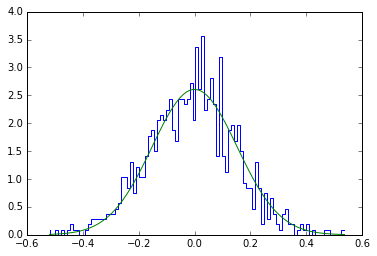

In [15]:
import scipy.optimize as opt
# popt, pcov = opt.curve_fit(Gaussian2D, (x, y), data_noisy, p0=initial_guess)

data = np.array( PcmX )
fig,ax=plt.subplots()
hist, bin_edges = np.histogram(data, density=True,bins=100)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
p0 = [1, 0.155]
popt, pcov = curve_fit(GaussianX, bin_centres, hist, p0=p0) # curve_fit(Gaussian1D, data.index, data)
hist_fit = GaussianX(bin_centres, *popt)
plt.step(bin_centres, hist, label='Test data')
plt.plot(bin_centres, hist_fit, label='Fitted data')

print popt
print pcov

# fit 2d gaussian

102.0
0.00119326568108 0.000727689553592
A: 83.217  +/- 0.375
mean_x: 0.044  +/- 0.001
mean_y: -0.037  +/- 0.001
sigma_x: 0.180  +/- 0.001
sigma_y: 0.142  +/- 0.001


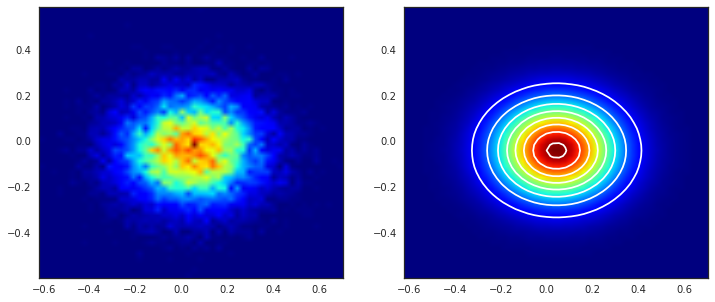

In [246]:
def Gaussian2D(( x , y), amplitude, mean_x , mean_y , sigma_x, sigma_y  ):
    amplitude = float(amplitude)
    ax = ((x - mean_x)**2)/(2*sigma_x**2)
    ay = ((y - mean_y)**2)/(2*sigma_y**2)
    g = ( amplitude / (sqrt2pi*sigma_x*sqrt2pi*sigma_y) ) * np.exp( - (ax + ay) )
    return g.ravel()

data = np.array( [PcmX,PcmY] )
hist, edges = np.histogramdd( data.T ,bins=50)
x_centres = (edges[0][:-1] + edges[0][1:])/2
y_centres = (edges[1][:-1] + edges[1][1:])/2
X,Y = np.meshgrid(x_centres,y_centres)

hist=hist.ravel()
print np.max(hist)
p0 = (np.max(hist), np.mean(PcmX) , np.mean(PcmY) , np.std(PcmX) , np.std(PcmY) )
popt, pcov = opt.curve_fit(Gaussian2D, (X,Y), hist, p0=p0)

fig= plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
im = ax.imshow(hist.reshape(len(x_centres),len(y_centres)), cmap=plt.cm.jet, origin='bottom',extent=(x_centres.min(), x_centres.max(), y_centres.min(), y_centres.max()))

ax = fig.add_subplot(1,2,2)
hist_fit = Gaussian2D( (X , Y), *popt)
im = ax.imshow(hist_fit.reshape(len(x_centres),len(y_centres)), cmap=plt.cm.jet, origin='bottom',extent=(x_centres.min(), x_centres.max(), y_centres.min(), y_centres.max()))
ax.contour( X , Y, hist_fit.reshape(len(x_centres),len(y_centres)), 8, colors='w');

# print pcov
print np.mean(PcmX) , np.mean(PcmY)
print 'A: %.3f'%popt[0],' +/- %.3f'%np.sqrt(pcov[0,0])
print 'mean_x: %.3f'%popt[1],' +/- %.3f'%np.sqrt(pcov[1,1])
print 'mean_y: %.3f'%popt[2],' +/- %.3f'%np.sqrt(pcov[2,2])
print 'sigma_x: %.3f'%popt[3],' +/- %.3f'%np.sqrt(pcov[3,3])
print 'sigma_y: %.3f'%popt[4],' +/- %.3f'%np.sqrt(pcov[4,4])


# fit 3d Gaussian 

In [187]:
def Gaussian3D(( x , y, z), amplitude, mean_x , mean_y , mean_z , sigma_x, sigma_y, sigma_z  ):
    amplitude = float(amplitude)
    ax = ((x - mean_x)**2)/(2*sigma_x**2)
    ay = ((y - mean_y)**2)/(2*sigma_y**2)
    az = ((z - mean_z)**2)/(2*sigma_z**2)
    g = ( amplitude / (sqrt2pi*sigma_x*sqrt2pi*sigma_y*sqrt2pi*sigma_z) ) * np.exp( - (ax + ay + az) )
    return g.ravel()

data = np.array( [PcmX,PcmY,PcmZ])
print data.T.shape
hist, edges = np.histogramdd( data.T ,bins=20)
x_centres = (edges[0][:-1] + edges[0][1:])/2
y_centres = (edges[1][:-1] + edges[1][1:])/2
z_centres = (edges[2][:-1] + edges[2][1:])/2

X,Y,Z = np.meshgrid(x_centres,y_centres,z_centres)

hist=hist.ravel()

p0 = (1, 0 , 0 , 0 , 0.155 , 0.155 , 0.2 )
popt, pcov = opt.curve_fit(Gaussian3D, (X,Y,Z), hist, p0=p0)

print [np.mean(PcmX),np.mean(PcmY),np.mean(PcmZ)]
print [np.std(PcmX),np.std(PcmY),np.std(PcmZ)]


# print pcov
print 'mean_x: %.3f'%popt[1],' +/- %.3f'%np.sqrt(pcov[1,1])
print 'mean_y: %.3f'%popt[2],' +/- %.3f'%np.sqrt(pcov[2,2])
print 'mean_z: %.3f'%popt[3],' +/- %.3f'%np.sqrt(pcov[3,3])
print 'sigma_x: %.3f'%popt[4],' +/- %.3f'%np.sqrt(pcov[4,4])
print 'sigma_y: %.3f'%popt[5],' +/- %.3f'%np.sqrt(pcov[5,5])
print 'sigma_z: %.3f'%popt[6],' +/- %.3f'%np.sqrt(pcov[6,6])




(20001, 3)
[0.0011932656810837391, 0.00072768955359161635, 0.054496678507747837]
[0.15646161740561293, 0.15587768376106997, 0.2342086085751699]
mean_x: 0.045  +/- 0.001
mean_y: -0.037  +/- 0.001
mean_z: -0.081  +/- 0.002
sigma_x: 0.182  +/- 0.001
sigma_y: 0.144  +/- 0.001
sigma_z: 0.336  +/- 0.002


# fit a 3d Gaussian with an offset in the Z-direction

In [154]:

def Gaussian3DwithOffset( (PcmX, PcmY , PcmZ , Pmiss) , amplitude , sigma_t , a1 , a2 , b1 , b2 ):
    amplitude = float(amplitude)
    mean_x = mean_y = 0
    sigma_x = sigma_t
    sigma_y = sigma_t 
    sigma_z = a1*(Pmiss - 0.6) + a2
    mean_z = b1*(Pmiss - 0.6 ) + b2
    ax = (np.square(PcmX - mean_x))/(2*np.square(sigma_x))
    ay = (np.square(PcmY - mean_y))/(2*np.square(sigma_y))
    az = (np.square(PcmZ - mean_z))/(2*np.square(sigma_z))
    g = ( amplitude / (sqrt2pi*sigma_x*sqrt2pi*sigma_y*sqrt2pi*sigma_z) ) * np.exp( - (ax + ay + az) )
    return g.ravel()

data = np.array( [PcmX,PcmY,PcmZ,Pmiss] )
print data.T.shape
hist, edges = np.histogramdd( data.T ,bins=10)
x_centres = (edges[0][:-1] + edges[0][1:])/2
y_centres = (edges[1][:-1] + edges[1][1:])/2
z_centres = (edges[2][:-1] + edges[2][1:])/2
pm_centres = (edges[3][:-1] + edges[3][1:])/2


X,Y,Z,PM = np.meshgrid(x_centres,y_centres,z_centres,pm_centres)

hist=hist.ravel()

p0 = ( 1 , 0.155 , 0.143 , 0.158 , 0.562 , 0.143  )
popt, pcov = opt.curve_fit(Gaussian3DwithOffset, (X,Y,Z,PM), hist, p0=p0)

# print pcov
print 'sigma_t: %.3f'%popt[1],' +/- %.3f'%np.sqrt(pcov[1,1])
print 'a1: %.3f'%popt[2],' +/- %.3f'%np.sqrt(pcov[2,2])
print 'a2: %.3f'%popt[3],' +/- %.3f'%np.sqrt(pcov[3,3])
print 'b1: %.3f'%popt[4],' +/- %.3f'%np.sqrt(pcov[4,4])
print 'b2: %.3f'%popt[5],' +/- %.3f'%np.sqrt(pcov[5,5])

(4532, 4)
sigma_t: 0.168  +/- 0.001
a1: 0.108  +/- 0.002
a2: 0.154  +/- 0.001
b1: 0.578  +/- 0.002
b2: 0.163  +/- 0.001


# fit the measured data in a similar way

In [168]:
# load the data
columns = ['Q2','theta (miss-q)','Pmiss3Mag','pcmX','pcmY','pcmZ']

ana = dict()
for target in ['C12','Al27','Fe56','Pb208']:
    data = read_root( path+"/AnaFiles/Ana_ppSRCcut_DATA_%s.root"%target, columns=columns )    
    ana[target]=data


In [297]:

def Gaussian3DwithOffset( (PcmX, PcmY , PcmZ , Pmiss) , amplitude , sigma_t , a1 , a2 , b1 , b2 ):
    mean_x = mean_y = 0
    sigma_x = sigma_t
    sigma_y = sigma_t 
    sigma_z = a1*(Pmiss - 0.6) + a2
    mean_z = b1*(Pmiss - 0.6 ) + b2
    ax = (np.square(PcmX - mean_x))/(2*np.square(sigma_x))
    ay = (np.square(PcmY - mean_y))/(2*np.square(sigma_y))
    az = (np.square(PcmZ - mean_z))/(2*np.square(sigma_z))
#     g = ( amplitude / (sqrt2pi*sigma_x*sqrt2pi*sigma_y*sqrt2pi*sigma_z) ) * np.exp( - (ax + ay + az) )
    g = ( float(amplitude) * np.exp( - (ax + ay + az) ) )

    return g.ravel()



In [326]:
def fit_5parameter(ana,do_print_cov=False):
    data = np.array( [ana.pcmX,ana.pcmY,ana.pcmZ,ana.Pmiss3Mag] )
    hist, edges = np.histogramdd( data.T ,bins=15)
    x_centres = (edges[0][:-1] + edges[0][1:])/2
    y_centres = (edges[1][:-1] + edges[1][1:])/2
    z_centres = (edges[2][:-1] + edges[2][1:])/2
    pm_centres = (edges[3][:-1] + edges[3][1:])/2


    X,Y,Z,PM = np.meshgrid(x_centres,y_centres,z_centres,pm_centres)

    hist=hist.ravel()

#     p0 = ( np.max(hist) , 0.165 , 0.2 , 0.2 , 0.562 , 0.2 )
    p0 = ( 4, 0.165 , 0.2 , 0.2 , 0.562 , 0.2 )
    popt, pcov = opt.curve_fit(Gaussian3DwithOffset, (X,Y,Z,PM), hist, p0=p0 )

    if do_print_cov: print pcov
    print np.max(hist)
    print 'amplitude: %.3f'%popt[0],' +/- %.3f'%np.sqrt(pcov[0,0])
    print 'sigma_t: %.3f'%popt[1],' +/- %.3f'%np.sqrt(pcov[1,1])
    print 'a1: %.3f'%popt[2],' +/- %.3f'%np.sqrt(pcov[2,2])
    print 'a2: %.3f'%popt[3],' +/- %.3f'%np.sqrt(pcov[3,3])
    print 'b1: %.3f'%popt[4],' +/- %.3f'%np.sqrt(pcov[4,4])
    print 'b2: %.3f'%popt[5],' +/- %.3f'%np.sqrt(pcov[5,5])


In [335]:
fit_5parameter(ana_synthetic,do_print_cov=True)

[[  2.73573990e-03  -9.17650220e-06  -8.11993522e-06  -9.58080137e-06
   -2.81594115e-07   3.65226542e-08]
 [ -9.17650220e-06   7.69657075e-08   3.51364445e-16   1.45538009e-16
    5.76512559e-17   9.51152380e-17]
 [ -8.11993522e-06   3.51363490e-16   6.31992521e-07   2.24333533e-07
   -2.88371074e-07  -2.06610957e-08]
 [ -9.58080137e-06   1.45537957e-16   2.24333533e-07   1.82508675e-07
   -1.32000854e-08  -2.24611018e-09]
 [ -2.81594115e-07   5.76540303e-17  -2.88371074e-07  -1.32000854e-08
    9.88037464e-07   2.82156522e-07]
 [  3.65226542e-08   9.51158234e-17  -2.06610957e-08  -2.24611018e-09
    2.82156522e-07   1.90358522e-07]]
28.0
amplitude: 18.741  +/- 0.052
sigma_t: 0.157  +/- 0.000
a1: 0.139  +/- 0.001
a2: 0.162  +/- 0.000
b1: 0.563  +/- 0.001
b2: 0.158  +/- 0.000


In [327]:
fit_5parameter(ana['C12'],do_print_cov=True)

[[  6.81934173e-05  -1.12913032e-05   2.89991396e-05  -9.59069445e-06
    1.16201451e-06   4.20429651e-07]
 [ -1.12913032e-05   4.59871286e-06  -4.45502965e-15   8.18141084e-16
    7.36748348e-16  -1.83664654e-15]
 [  2.89991396e-05  -4.45520047e-15   7.51286698e-05  -2.28519802e-05
   -1.86939739e-07   5.60931347e-06]
 [ -9.59069445e-06   8.18201706e-16  -2.28519802e-05   7.63600072e-06
    4.86971328e-06  -2.04328763e-06]
 [  1.16201451e-06   7.36871894e-16  -1.86939739e-07   4.86971328e-06
    9.78311076e-05  -2.28397349e-05]
 [  4.20429651e-07  -1.83668203e-15   5.60931347e-06  -2.04328763e-06
   -2.28397349e-05   7.52411248e-06]]
4.0
amplitude: 0.343  +/- 0.008
sigma_t: 0.140  +/- 0.002
a1: -0.320  +/- 0.009
a2: 0.112  +/- 0.003
b1: 0.694  +/- 0.010
b2: 0.089  +/- 0.003


In [324]:
fit_5parameter(ana['Al27'])

2.0
amplitude: 0.035  +/- 0.002
sigma_t: 0.282  +/- 0.014
a1: 0.000  +/- 0.027
a2: 0.107  +/- 0.006
b1: 0.703  +/- 0.033
b2: 0.141  +/- 0.006


In [325]:
fit_5parameter(ana['Fe56'])

3.0
amplitude: 0.220  +/- 0.006
sigma_t: 0.174  +/- 0.003
a1: 0.000  +/- 0.013
a2: 0.120  +/- 0.003
b1: 0.490  +/- 0.015
b2: 0.144  +/- 0.003


In [319]:
fit_5parameter(ana['Pb208'])

2.0
amplitude: 0.024  +/- 0.002
sigma_t: 0.217  +/- 0.012
a1: 0.000  +/- 0.052
a2: 0.159  +/- 0.012
b1: 0.695  +/- 0.061
b2: 0.141  +/- 0.012


In [334]:
ana_synthetic.to_csv("synthetic_sample.csv")